In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

np.random.seed(42)
tf.random.set_seed(42)

2023-12-14 09:59:26.220033: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 09:59:26.220095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 09:59:26.220974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 09:59:26.229015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 09:59:26.940718: W tensorflow/compiler/tf2

In [2]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


2023-12-14 09:59:27.621238: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 09:59:27.654616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 09:59:27.654678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 09:59:27.893177: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 09:59:27.893247: I external/local_xla/xla/stream_executor

In [3]:
combined_faces_zip_path = "./inputs/combined_faces.zip"
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [4]:


combined_faces_zip_path = "./inputs/combined_faces_train_augmented.zip"
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping combined_faces_train_augmented.zip')

train_aug_df = pd.read_csv("./inputs/images_filenames_labels_train_augmented.csv")
test_df = pd.read_csv("./inputs/images_filenames_labels_test.csv")

Done unzipping combined_faces_train_augmented.zip


In [5]:
def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [6]:
train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])
test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

2023-12-14 10:03:01.682899: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 10:03:01.683022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 10:03:01.683064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 10:03:01.683358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-14 10:03:01.683411: I external/local_xla/xla/stream_executor

In [7]:
num_classes = 7
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
train_aug_dataset = train_aug_dataset.batch(150)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(150)  

In [8]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
final_cnn.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(GlobalAveragePooling2D())

final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dense(7, activation='softmax'))
final_cnn.summary()

final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir=f"./outputs/cnn_logs")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      160       
                                                                 
 average_pooling2d (Average  (None, 99, 99, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 average_pooling2d_1 (Avera  (None, 48, 48, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 average_pooling2d_2 (Avera  (None, 23, 23, 64)        0

In [9]:
checkpoint = ModelCheckpoint(filepath=f"./outputs/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

final_cnn_history = final_cnn.fit(train_aug_dataset,
                                #   batch_size=512,
                                    batch_size=150,
                                  validation_data=test_dataset,
                                #   epochs=60,
                                    epochs=30,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False
                                 )

Epoch 1/30


2023-12-14 10:04:55.869124: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-14 10:04:57.178314: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f42251977b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-14 10:04:57.178354: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-12-14 10:04:57.195092: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702527597.312918    7988 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - ETA: 0s - loss: 1.5490 - accuracy: 0.3907
Epoch 1: val_accuracy improved from -inf to 0.47153, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 77s 44ms/step - loss: 1.5490 - accuracy: 0.3907 - val_loss: 1.3079 - val_accuracy: 0.4715
Epoch 2/30
   1/1563 [..............................] - ETA: 1:31 - loss: 1.1443 - accuracy: 0.5533

/home/bilson/projects/gender-age/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1563 [==============================] - ETA: 0s - loss: 1.2591 - accuracy: 0.4830
Epoch 2: val_accuracy did not improve from 0.47153
1563/1563 [==============================] - 63s 40ms/step - loss: 1.2591 - accuracy: 0.4830 - val_loss: 1.4842 - val_accuracy: 0.4025
Epoch 3/30
1563/1563 [==============================] - ETA: 0s - loss: 1.1107 - accuracy: 0.5355
Epoch 3: val_accuracy improved from 0.47153 to 0.57336, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 63s 40ms/step - loss: 1.1107 - accuracy: 0.5355 - val_loss: 1.0418 - val_accuracy: 0.5734
Epoch 4/30
1562/1563 [============================>.] - ETA: 0s - loss: 1.0130 - accuracy: 0.5740
Epoch 4: val_accuracy improved from 0.57336 to 0.59228, saving model to ./outputs/cnn_logs/age_model_checkpoint.h5
1563/1563 [==============================] - 62s 40ms/step - loss: 1.0130 - accuracy: 0.5740 - val_loss: 0.9784 - val_accuracy: 0.5923
Epoch 5/30
1562/1563 [=========

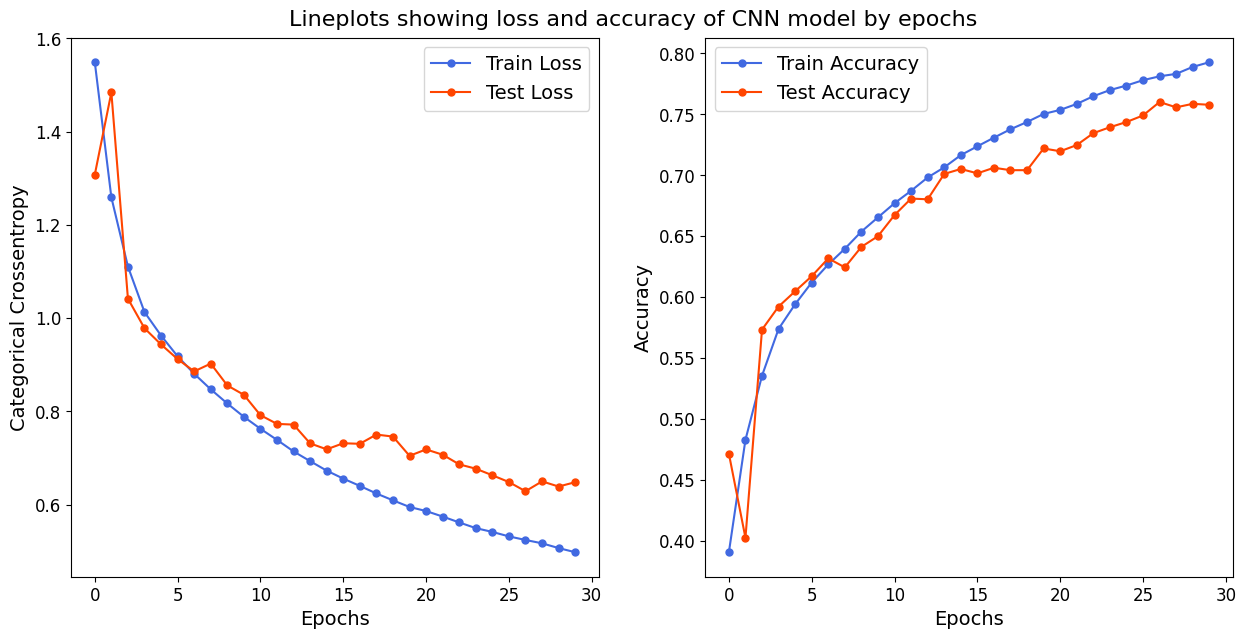

In [10]:
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

plt.savefig('./outputs/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');

67/67 [==============================] - 1s 20ms/step - loss: 0.6480 - accuracy: 0.7578
CNN model loss 		= 0.648
CNN model accuracy 	= 0.758
INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


67/67 [==============================] - 1s 20ms/step
Normalized confusion matrix


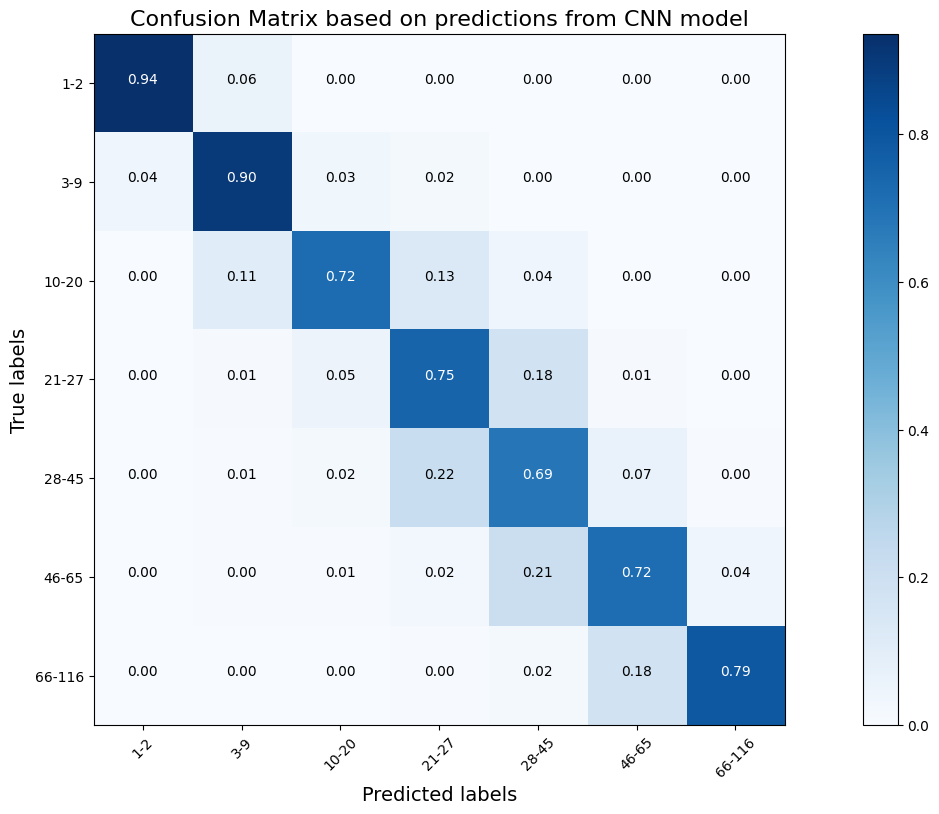

In [11]:
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)

final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

final_cnn.save("./saved_model/", save_format='tf')

final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    plt.savefig(f'./outputs/cnn_logs/{export_as}.png', bbox_inches='tight');
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()